## Imports

In [1]:
## resolver problema no caminho do maturin do pyo3, que faz a biblioteca em rust ser acessível em python
import sys, os
for cam in sys.path:
    if cam.find('LSTM') != -1:
        caminho = os.path.join(cam, 'rust_funcs', '.env', 'Lib', 'site-packages', 'rust_funcs')
        print(caminho)
        break
sys.path.append(caminho)
import rust_funcs
sys.path.remove(caminho)
del caminho

import numpy as np

c:\Users\brunO\AreadeTrabalho\Prog\Python\LSTM\rust_funcs\.env\Lib\site-packages\rust_funcs


In [2]:
def relu(x):
    return (x > 0)*x

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return (tanh(x/2)+1)/2

def logloss(y, yhat):
    return rust_funcs.logloss(y, yhat)

def crossentropy(y,yhat):
    return rust_funcs.crossentropy(y,yhat)

def quaderror(x, y, f = None):
    if f:
        return np.dot(f(x) - y, f(x) - y)/(2*len(y))
    return rust_funcs.quaderror(x,y)

664 ns ± 44.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
2.02 µs ± 12 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
669 ns ± 3.43 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
2.03 µs ± 40.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.25 µs ± 5.99 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
3.56 µs ± 91.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.9 µs ± 58.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
11.8 µs ± 85.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
94 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
119 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
6.76 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.8 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.2 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
73.6 ms ± 945 µs per loop (mean

C:\Users\brunO\AppData\Local\Temp\ipykernel_3672\1211789004.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe.set_xticklabels(list(range(0,_ordem-1)))


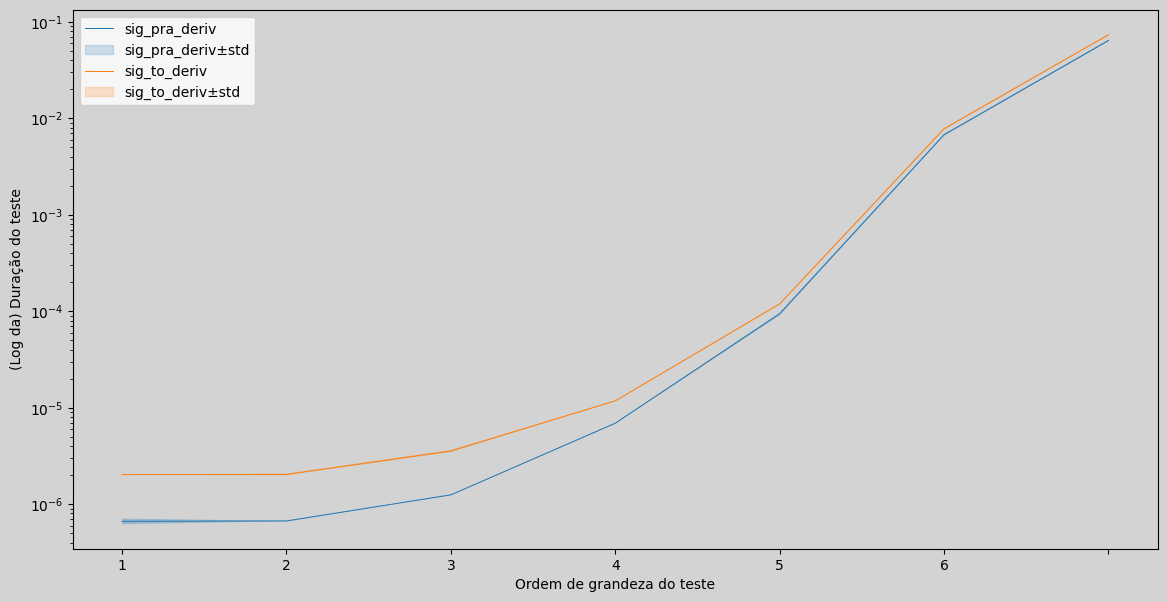

In [6]:
## teste de tempo entre funções (principalmente para o Rust)

def fazer_fig(listas, listas_std, lista_f):
    import seaborn as sns, matplotlib.pyplot as plt
    fig, axe = plt.subplots(figsize=(14,7), facecolor='lightgray')
    axe.set_facecolor('lightgray')
    for i in range(len(listas)):
        sns.lineplot(data=listas[i], ax=axe, linewidth=0.7)
    for i in range(len(listas)):
        lower_bound = [M_new - Sigma for M_new, Sigma in zip(listas[i], listas_std[i])]
        upper_bound = [M_new + Sigma for M_new, Sigma in zip(listas[i], listas_std[i])]
        plt.fill_between(list(range(_ordem-1)), lower_bound, upper_bound, alpha=.3)
    plt.yscale('log')
    axe.legend([lista_f[i//2].__name__ if not i%2 else lista_f[i//2].__name__+'±std' for i in range(0,2*len(lista_f))])
    axe.set_xlabel('Ordem de grandeza do teste')
    axe.set_ylabel('(Log da) Duração do teste')
    axe.set_xticklabels(list(range(0,_ordem-1)))
    plt.show()

def single_test(n, f, lista_f, y, yhat):
    # print(y.shape, yhat.shape)
    # print(rust_funcs.matrix_vec(y,yhat).shape)
    # print([g(y,yhat) for g in lista_f])
    assert(np.all(np.isclose([[f(yhat) for f in lista_f]], lista_f[0](yhat))))
    number = %timeit -o f(yhat)
    return number

def testar(lista_f):
    k = len(lista_f)
    listas = [[] for i in range(k)]
    global _ordem
    _ordem = 8
    for n in range(1, _ordem):

        y = 0#(np.random.random([10**n-1,10**n-1])+0.5)
        yhat = np.linspace(0.05,0.95, 10**n-1)

        for i in range(k):
            listas[i].append(single_test(n, lista_f[i], lista_f, y, yhat))
    listas_std = [[] for i in range(k)]
    for j in range(len(listas[0])):
        for i in range(k):
            listas_std[i].append(listas[i][j].stdev)
            listas[i][j] = listas[i][j].average 
    fazer_fig(listas, listas_std, lista_f)
    
# testar([rust_funcs.sig_pra_deriv, sig_to_deriv])
   

<div align="center">

![LSTM](.\\lstm_diagram.png)

</div>

In [25]:
# Reference [1]: Learning Precise Timing with LSTM Recurrent Networks,
# Felix A. Gers, Nicol N. Schraudolph and J¨urgen Schmidhuber

class Node:
    def __init__(
            self,
            m: int,
            n: int,
            activation = sigmoid
        ) -> None:
        # conjoint weights for h and x: self.weight is [U|W]
        # so that [U|W][h|x] = Uh + Wx
        self.weight = np.random.random([n, n + m])
        self.bias = np.zeros(n)
        self.activation = activation
        pass

    def forward_pass(self, input) -> np.ndarray:
        # self.activation( np.add(np.matmul(self.weight, input), self.bias))
        return self.activation( np.add(self.weight @ input, self.bias) )
        
class Cell:
    def __init__(
            self,
            input_shape: int, # m
            output_shape: int, # n
            steps_update: int, # h
            output_activation: str = 'tanh'
    ) -> None:
        self.hidden_state = np.zeros(output_shape)
        self.memory = np.zeros(output_shape)
        self.last_memory = None
        self.forg_gate = Node(input_shape, output_shape)
        self.in_gate = Node(input_shape, output_shape)
        self.out_gate = Node(input_shape, output_shape)
        ## tanh abaixo deveria ser opcional segundo o artigo [1], mas afeta o update das derivadas parciais 
        self.input_activation = Node(input_shape, output_shape, activation = tanh)
        match output_activation:
            case 'tanh':
                self.output_activation = tanh
            case 'identity':
                self.output_activation = lambda x : x
        ## RTRL partial derivatives
        self.input_partials = np.zeros((output_shape, output_shape + input_shape, steps_update))
        self.forget_partials = np.zeros((output_shape, output_shape + input_shape, steps_update))
        self.memory_partials = np.zeros((output_shape, output_shape + input_shape, steps_update))

        self.steps_update = steps_update
        self.output_shape = output_shape
        self.input_shape = input_shape
        
    def forward_pass(self, x_t, t): ##TODO: algum tipo de loop pra passar x_t cada vez
        ## Save "last" memory, used in partials (vector copy, otherwise change code)
        self.last_memory = self.memory
        ## Concatenate hidden state H_(t-1) with  X_t
        input = np.append(self.hidden_state, x_t)
        ## pass through forget gate, saving result
        res_forg_gate = self.forg_gate.forward_pass(input)
        ## Update memory with result from forget gate
        np.multiply(
            self.memory,
            res_forg_gate,
            out=self.memory
        )
        ## pass through input gate, saving result 
        res_in_gate = self.in_gate.forward_pass(input)
        ## pass through main gate, saving result 
        res_main = self.input_activation.forward_pass(input)
        ## update memory with result from  input and main gates
        np.add(
            self.memory,
            np.multiply(res_in_gate, res_main),
            out=self.memory
        )
        ## pass through output gate, saving result 
        res_out_gate = self.out_gate.forward_pass(input)
        ## update self.hidden_state:
        ## H_t = hidden state = output = activation(memory) \odot outputGate
        np.multiply(
            self.output_activation(self.memory),
            res_out_gate,
            out = self.hidden_state
        )
        self.update_partials(self, input, res_forg_gate, res_in_gate, res_main, (t % self.steps_update) + 1)
        if t == self.steps_update:
            ## TODO: backward pass
            self.input_partials = np.zeros((self.output_shape, self.output_shape + self.input_shape, self.steps_update))
            self.forget_partials = np.zeros((self.output_shape, self.output_shape + self.input_shape, self.steps_update))
            self.memory_partials = np.zeros((self.output_shape, self.output_shape + self.input_shape, self.steps_update))

    def update_partials(self, input, res_forg_gate, res_in_gate, res_main, t):
        ## Equation 13 of [1]
        np.multiply(self.input_partials[:,:,t-1], res_forg_gate.reshape(-1,1), out=self.input_partials[:,:,t])
        np.add(
            self.input_partials[:,:,t],
            np.multiply(
                input,
                np.multiply(res_main, rust_funcs.sig_pra_deriv(res_in_gate)).reshape(-1,1)
            ),
            out= self.input_partials[:,:,t]
        )
        ## Equation 14 of [1]
        np.multiply(self.forget_partials[:,:,t-1], res_forg_gate.reshape(-1,1), out=self.forget_partials[:,:,t])
        np.add(
            self.forget_partials[:,:,t],
            np.multiply(
                input,
                np.multiply(self.last_memory, rust_funcs.sig_pra_deriv(res_forg_gate)).reshape(-1,1)
            ),
            out= self.forget_partials[:,:,t]
        )
        ## Equation 12 of [1]
        np.multiply(self.memory_partials[:,:,t-1], res_forg_gate.reshape(-1,1), out=self.memory_partials[:,:,t])
        np.add(
            self.memory_partials[:,:,t],
            np.multiply(
                input,
                np.multiply(rust_funcs.tanh_pra_deriv(res_main), res_in_gate).reshape(-1,1)
            ),
            out= self.memory_partials[:,:,t]
        )
    
    # def backward_pass(self, error_signal) -> None:
        ## input
        ## forget
        ## cell input and state
        ## output gate activation and cell output



(5, 2)
[0. 0. 0. 0. 0.]
[0.12062209 0.19934761 0.2609805  0.1229702  0.1912376 ]
[0.38229535 0.48963988 0.56287583 0.37360005 0.46158249]
[0.71271981 0.75531445 0.79514141 0.68638761 0.73497395]
[0.89748597 0.89153653 0.91114547 0.86475542 0.87911375]
[0.95297785 0.93266068 0.94704239 0.91877009 0.92260566]
[0.96637202 0.94202465 0.9557381  0.93081752 0.93243733]
[0.96961853 0.94397935 0.95778006 0.93330226 0.93447977]
[0.97047235 0.94438894 0.95829153 0.93382506 0.93490966]
[0.97072286 0.94447939 0.95843434 0.93394264 0.93500622]
[0.97080527 0.94450121 0.95847953 0.93397183 0.93503024]
[0.97083545 0.94450712 0.95849569 0.93398001 0.93503704]
[0.97084761 0.94450896 0.95850213 0.93398264 0.93503925]
[0.97085293 0.9445096  0.95850494 0.93398359 0.93504006]
[0.97085544 0.94450987 0.95850628 0.93398399 0.9350404 ]
[0.9708567  0.94450998 0.95850695 0.93398416 0.93504056]
[0.97085737 0.94451004 0.95850732 0.93398425 0.93504063]
[0.97085774 0.94451007 0.95850752 0.93398429 0.93504067]
[0.9708

In [ ]:
## projeto de teste
celula = Cell(5,5)
array = np.array([[0.2,0.2,0.2,0.2,0.2],[0.2,0.2,0.2,0.2,0.2]]).T
print(array.shape)
for i in range(20):
    for column in range(array.shape[1]):
        print(celula.hidden_state)
        celula.forward_pass(array[:,column])